In [1]:
# Requirements:
# !pip install rtdl
# !pip install libzero==0.0.4

In [2]:
from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero
import pandas as pd

In [3]:
device = torch.device('cpu')
# Docs: https://yura52.github.io/zero/0.0.4/reference/api/zero.improve_reproducibility.html
zero.improve_reproducibility(seed=123456)

123456

### Data

In [4]:
df = pd.read_csv("data/adult_processed.csv")

In [5]:
# df.values

target = df["target"].values
targetValues = list(set(target))
targetMapping = dict()


for i in range(len(targetValues)):
    targetMapping[targetValues[i]] = i

result = []
for t in target:
    result.append(targetMapping[t])

dfFormat = {"target": pd.DataFrame(result).values.reshape(df.shape[0]), "data": df.drop("target", axis=1), "frame": None, "DESCR": "Todo", "feature_names": []}

In [6]:
def toY(_data):
    if type(_data) == np.ndarray:
        return _data
    else:
        return _data.values

In [7]:
targetMapping

{'>50K': 0, '<=50K': 1}

In [8]:
task_type = 'multiclass'

assert task_type in ['binclass', 'multiclass', 'regression']

X_all = dfFormat['data'].astype('float32')
y_all = dfFormat['target'].astype('float32' if task_type == 'regression' else 'int64')
if task_type != 'regression':
    y_all = sklearn.preprocessing.LabelEncoder().fit_transform(y_all).astype('int64')
n_classes = int(max(y_all)) + 1 if task_type == 'multiclass' else None

oldX = {}
y = {}
oldX['train'], oldX['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
    X_all, y_all, train_size=0.8
)
oldX['train'], oldX['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    oldX['train'], y['train'], train_size=0.8
)

# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(oldX['train'])
X = {
    # k: torch.tensor(v, device=device)
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in oldX.items()
}
# y = {k: torch.tensor(np.array(v), device=device) for k, v in y.items()}
y = {k: torch.tensor(toY(v), device=device) for k, v in y.items()}

# !!! CRUCIAL for neural networks when solving regression problems !!!
if task_type == 'regression':
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
else:
    y_std = y_mean = None

if task_type != 'multiclass':
    y = {k: v.float() for k, v in y.items()}

### Model
Carefully read the comments and uncomment the code for the model you want to test.

In [9]:
def createModel():
    d_out = n_classes or 1


    first_layer = 4
    model = rtdl.MLP.make_baseline(
        d_in=X_all.shape[1],
    #     d_layers=[first_layer, 256, 128],
        d_layers=[first_layer, 8, first_layer],
        dropout=0.1,
        d_out=d_out,
        # seed=42
    )
    lr = 0.001
    weight_decay = 0.0

    # model = rtdl.ResNet.make_baseline(
    #     d_in=X_all.shape[1],
    #     d_main=128,
    #     d_intermidiate=256,
    #     dropout_first=0.2,
    #     dropout_second=0.0,
    #     n_blocks=2,
    #     d_out=d_out,
    # )
    # lr = 0.001
    # weight_decay = 0.0

    # model = rtdl.FTTransformer.make_default(
    #     n_num_features=X_all.shape[1],
    #     cat_cardinalities=None,
    #     last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    #     d_out=d_out,
    # )

    # === ABOUT CATEGORICAL FEATURES ===
    # IF you use MLP, ResNet or any other simple feed-forward model (NOT transformer-based model)
    # AND there are categorical features
    # THEN you have to implement a wrapper that handles categorical features.
    # The example below demonstrates how it can be achieved using rtdl.CategoricalFeatureTokenizer.
    # ==================================
    # 1. When you have both numerical and categorical features, you should prepare you data like this:
    #    (X_num<float32>, X_cat<int64>) instead of X<float32>
    #    Each column in X_cat should contain values within the range from 0 to <(the number of unique values in column) - 1>;
    #    use sklean.preprocessing.OrdinalEncoder to achieve this;
    # 2. Prepare a list of so called "cardinalities":
    #    cardinalities[i] = <the number of unique values of the i-th categorical feature>
    # 3. See the commented example below and adapt it for your needs.
    #
    # class Model(nn.Module):
    #     def __init__(
    #         self,
    #         n_num_features: int,
    #         cat_tokenizer: rtdl.CategoricalFeatureTokenizer,
    #         mlp_kwargs: Dict[str, Any],
    #     ):
    #         super().__init__()
    #         self.cat_tokenizer = cat_tokenizer
    #         self.model = rtdl.MLP.make_baseline(
    #             d_in=n_num_features + cat_tokenizer.n_tokens * cat_tokenizer.d_token,
    #             **mlp_kwargs,
    #         )
    #
    #     def forward(self, x_num, x_cat):
    #         return self.model(
    #             torch.cat([x_num, self.cat_tokenizer(x_cat).flatten(1, -1)], dim=1)
    #         )
    #
    # model = Model(
    #     # `None` means "Do not transform numerical features"
    #     # `d_token` is the size of embedding for ONE categorical feature
    #     X_num_all.shape[1],
    #     rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
    #     mlp_kwargs,
    # )
    # Then the model should be used as `model(x_num, x_cat)` instead of of `model(x)`.

    model.to(device)
    optimizer = (
        model.make_default_optimizer()
        if isinstance(model, rtdl.FTTransformer)
    #     else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        else torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    )
    loss_fn = (
        F.binary_cross_entropy_with_logits
        if task_type == 'binclass'
        else F.cross_entropy
        if task_type == 'multiclass'
        else F.mse_loss
    )
    return model, optimizer, loss_fn


In [10]:
model, optimizer, loss_fn = createModel()

### Training

In [11]:
def apply_model(x_num, x_cat=None, model=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part, model):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 1024):
        prediction.append(apply_model(batch,model=model))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score


# Create a dataloader for batches of indices
# Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
batch_size = 256
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

# Create a progress tracker for early stopping
# Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test",model):.4f}')

Test score before training: 0.2394


In [12]:
from matplotlib import pyplot as plt

def plotLosses(_losses, title="this is a graph"):
    for key in _losses:
        plt.plot([np.log(x) for x in _losses[key]], label=key)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title(title)
    plt.show()
    plt.close()

In [13]:
def learnThat(_model, _optimizer, _loss_fn, _evaluate, _progress,_X, _y, _epochs, _batch_size,_train_loader, _relational_batch, _old_X, print_mode):

    report_frequency = len(X['train']) // _batch_size // 5
    losses = dict()
    losses['val']  = []
    losses['test'] = []
    for epoch in range(1, _epochs + 1):
        for iteration, batch_idx in enumerate(train_loader):
            _model.train()
            _optimizer.zero_grad()
            x_batch = _X['train'][batch_idx]
            y_batch = _y['train'][batch_idx]
            loss = _loss_fn(apply_model(x_batch,model=_model).squeeze(1), y_batch)
            loss.backward()

            factors = dict()

            ## Modify gradients
            if _relational_batch:
                for name, param in model.named_parameters():
                    if name=="blocks.0.linear.weight":                    
                        column_count = df.shape[1] - 1
                        factors = torch.ones(column_count,param.grad.shape[0])
                        for i in range(column_count):
                            column = oldX['train'].columns[i]
                            if True:# not column in oldNames:
                                idx = oldX['train'][iteration * batch_size:(iteration+1) * batch_size].columns[i]
                                realCount = oldX['train'][iteration * batch_size:(iteration+1) * batch_size][idx].sum()
                                if realCount > 0:
                                    factors[i] = (batch_size / (1.0 * realCount)) * factors[i]
                                else:
                                    ()
                                    # factors[i] = float('nan') * factors[i] 
                        param.grad = torch.mul(param.grad, torch.transpose(factors,0,1))

            optimizer.step()
            if iteration % report_frequency == 0:
                batch = "batch"
                if relational_batch:
                    batch= "relational-batch"
                print(f'(epoch) {epoch} ({batch}) {iteration} (loss) {loss.item():.4f}')


        losses['val'].append(float(loss_fn(apply_model(X['val'],model=_model).squeeze(1), y['val'])))
        losses['test'].append(float(loss_fn(apply_model(X['test'],model=_model).squeeze(1), y['test'])))


        val_score  = _evaluate('val',_model)
        test_score = _evaluate('test',_model)
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
        _progress.update((-1 if task_type == 'regression' else 1) * val_score)
        if _progress.success:
            print(' <<< BEST VALIDATION EPOCH', end='')
        print()
        if _progress.fail:
            break
    if print_mode:
        plotLosses(losses, "relational batch ? " + str(_relational_batch))
    return losses

In [14]:
epochs = 10
relational_batch = True

(epoch) 1 (relational-batch) 0 (loss) 0.7305
(epoch) 1 (relational-batch) 16 (loss) 0.7053
(epoch) 1 (relational-batch) 32 (loss) 0.6830
(epoch) 1 (relational-batch) 48 (loss) 0.6704
(epoch) 1 (relational-batch) 64 (loss) 0.6504
(epoch) 1 (relational-batch) 80 (loss) 0.6433
Epoch 001 | Validation score: 0.7518 | Test score: 0.7606 <<< BEST VALIDATION EPOCH
(epoch) 2 (relational-batch) 0 (loss) 0.6393
(epoch) 2 (relational-batch) 16 (loss) 0.6289
(epoch) 2 (relational-batch) 32 (loss) 0.6055
(epoch) 2 (relational-batch) 48 (loss) 0.6023
(epoch) 2 (relational-batch) 64 (loss) 0.5689
(epoch) 2 (relational-batch) 80 (loss) 0.5586
Epoch 002 | Validation score: 0.7518 | Test score: 0.7606
(epoch) 3 (relational-batch) 0 (loss) 0.5565
(epoch) 3 (relational-batch) 16 (loss) 0.5228
(epoch) 3 (relational-batch) 32 (loss) 0.4756
(epoch) 3 (relational-batch) 48 (loss) 0.4698
(epoch) 3 (relational-batch) 64 (loss) 0.4213
(epoch) 3 (relational-batch) 80 (loss) 0.4350
Epoch 003 | Validation score: 0.8

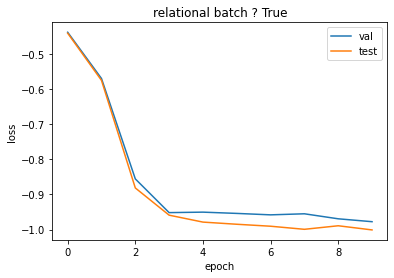

{'val': [0.6457823514938354,
  0.5659644603729248,
  0.4250175654888153,
  0.38603881001472473,
  0.3865619897842407,
  0.3851653039455414,
  0.38359254598617554,
  0.3847501873970032,
  0.3792893886566162,
  0.3761710524559021],
 'test': [0.6440256237983704,
  0.5629012584686279,
  0.41418126225471497,
  0.38323545455932617,
  0.3757407069206238,
  0.37343406677246094,
  0.3713442385196686,
  0.3680896461009979,
  0.37183013558387756,
  0.36745232343673706]}

In [15]:
learnThat(
    _model    =model, 
    _optimizer=optimizer, 
    _loss_fn  =loss_fn, 
    _evaluate =evaluate, 
    _progress =progress,
    _X=X, 
    _y=y, 
    _epochs      =epochs, 
    _batch_size  =batch_size,
    _train_loader=train_loader, 
    _relational_batch=relational_batch, 
    _old_X=oldX,
    print_mode=True)

In [16]:
model, optimizer, loss_fn = createModel()
epochs = 10
relational_batch = False

(epoch) 1 (batch) 0 (loss) 0.9006
(epoch) 1 (batch) 16 (loss) 0.8593
(epoch) 1 (batch) 32 (loss) 0.8402
(epoch) 1 (batch) 48 (loss) 0.7820
(epoch) 1 (batch) 64 (loss) 0.7722
(epoch) 1 (batch) 80 (loss) 0.7280
Epoch 001 | Validation score: 0.3622 | Test score: 0.3527
(epoch) 2 (batch) 0 (loss) 0.7162
(epoch) 2 (batch) 16 (loss) 0.6626
(epoch) 2 (batch) 32 (loss) 0.5894
(epoch) 2 (batch) 48 (loss) 0.5770
(epoch) 2 (batch) 64 (loss) 0.5065
(epoch) 2 (batch) 80 (loss) 0.4898
Epoch 002 | Validation score: 0.8134 | Test score: 0.8171
(epoch) 3 (batch) 0 (loss) 0.4754
(epoch) 3 (batch) 16 (loss) 0.4639
(epoch) 3 (batch) 32 (loss) 0.3675
(epoch) 3 (batch) 48 (loss) 0.4283
(epoch) 3 (batch) 64 (loss) 0.3741
(epoch) 3 (batch) 80 (loss) 0.3964
Epoch 003 | Validation score: 0.8351 | Test score: 0.8313 <<< BEST VALIDATION EPOCH
(epoch) 4 (batch) 0 (loss) 0.4192
(epoch) 4 (batch) 16 (loss) 0.4229
(epoch) 4 (batch) 32 (loss) 0.3515
(epoch) 4 (batch) 48 (loss) 0.4195
(epoch) 4 (batch) 64 (loss) 0.3628

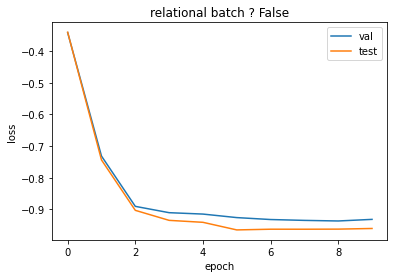

{'val': [0.7106124758720398,
  0.4810832142829895,
  0.41040095686912537,
  0.40228071808815,
  0.40051236748695374,
  0.39608606696128845,
  0.3936714231967926,
  0.39261212944984436,
  0.39187732338905334,
  0.3938664495944977],
 'test': [0.7113490700721741,
  0.47522231936454773,
  0.40527182817459106,
  0.39264148473739624,
  0.3902225196361542,
  0.3809652030467987,
  0.38181430101394653,
  0.3817978501319885,
  0.38191261887550354,
  0.382699191570282]}

In [17]:
learnThat(
    _model    =model, 
    _optimizer=optimizer, 
    _loss_fn  =loss_fn, 
    _evaluate =evaluate, 
    _progress =progress,
    _X=X, 
    _y=y, 
    _epochs      =epochs, 
    _batch_size  =batch_size,
    _train_loader=train_loader, 
    _relational_batch=relational_batch, 
    _old_X=oldX,
    print_mode=True)